# Object Detection

In this assignment, you will implement a fruit detector. 
The task is divided into steps for simpler navigation.

Let's start!

In [ ]:
# we will need this library to process the labeling
! pip install xmltodict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install albumentations==0.5.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip uninstall opencv-python-headless==4.5.5.62
!pip install opencv-python-headless==4.5.2.52

Found existing installation: opencv-python-headless 4.5.2.52
Uninstalling opencv-python-headless-4.5.2.52:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.2.52.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-8daa01ff.so.58.109.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-06a336f2.so.58.61.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-01d48d95.so.56.60.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-098682aa.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libpng15-c2ffaf3d.so.15.13.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libssl-f3db6a3b.so.1.1
    /usr/local/lib/python3.7/dist-package

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import xmltodict
import json
import glob
import cv2
import os
import torchvision
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [ ]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train_data_location = "/content/gdrive/My Drive/HSE/train"
test_data_location = "/content/gdrive/My Drive/HSE/test"

In [ ]:
import matplotlib.patches as patches

In [ ]:
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

## Step 0. Dataset

First, let's load the data that you can download [here](https://drive.google.com/file/d/1Ve5e9qdy_sUCMM4qXWrw8ecURg2af9Cm/view?usp=sharing). 

We have already written a dataset class for you and we encourage you to figure out how it works.

In [ ]:
class2tag = {"apple": 1, "orange": 2, "banana": 3}


class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform

        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
         
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(class2tag[obj["name"]])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            # the following code is correct if you use albumentations
            # if you use torchvision transforms you have to modify it
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"],
                labels=self.annotations[i]["labels"],
            )
            return res["image"], {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"]),
            }
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

In [ ]:
data = FruitDataset(train_data_location)
print(len(data))

240


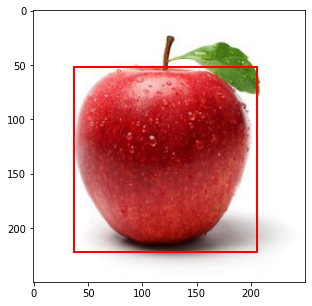

In [ ]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
num = 0
img, target = data[num]
plot_img_bbox(img, target)

In [ ]:

print(data.annotations[num])
print(data.annotations[num]['boxes'].numpy())
print(data.annotations[num]['labels'].numpy())


{'boxes': tensor([[ 37.,  52., 205., 222.]]), 'labels': tensor([1])}
[[ 37.  52. 205. 222.]]
[1]


## Step 1. Intersection over Union (10 points)

In the [Object Detection task](https://en.wikipedia.org/wiki/Object_detection), you need to find objects of a certain class on the image and locate their positions (using the bounding box). The  model should predict the coordinates of the bounding box `[x0, y0, x1, y1]` and the label for this box. The model can predict multiple candidate bounding boxes for an object. We will select candidates using [Intersection Over Union](https://en.wikipedia.org/wiki/Jaccard_index).

<img src=https://upload.wikimedia.org/wikipedia/commons/c/c7/Intersection_over_Union_-_visual_equation.png>


Implement a function that will calculate IoU for bounding boxes.

In [ ]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """
    ## YOUR CODE HERE
    x_lower = max(dt_bbox[0], gt_bbox[0])
    y_lower = max(dt_bbox[1], gt_bbox[1])
    x_upper = min(dt_bbox[2], gt_bbox[2])
    y_upper = min(dt_bbox[3], gt_bbox[3])

    AoO = max(0, x_upper - x_lower) * max(0, y_upper - y_lower)
    
    dt_A = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    gt_A = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])
   
    iou = AoO/float(dt_A + gt_A - AoO)  

    return iou

If the function is implemented correctly, then the execution of the following cell will produce:

**0.14285714285714285**

In [ ]:
dt_bbox = [0, 0, 2, 2]
gt_bbox = [1, 1, 3, 3]
intersection_over_union(dt_bbox, gt_bbox)

0.14285714285714285

## Step 2. Evaluate Sample (15 points)

We now have to evaluate the predictions of the model. To do this, we will write a function that will do the following:
1. Take model predictions and ground truth bounding boxes and labels as inputs.
2. For each bounding box from the prediction, find the closest bounding box among the answers.
3. For each found pair of bounding boxes, check whether the IoU is greater than a certain threshold `iou_threshold`. If the **IoU** exceeds the threshold, then we consider this answer as **True Positive**.
4. Remove a matched bounding box from the evaluation.
5. For each predicted bounding box, return the detection score and whether we were able to match it or not.

In [ ]:
def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    # ground truth
    gt_bboxes = target_true['boxes'].numpy()
    gt_labels = target_true['labels'].numpy()

    # predictions
    dt_bboxes = target_pred['boxes'].numpy()
    dt_labels = target_pred['labels'].numpy()
    dt_scores = target_pred['scores'].numpy()

    results = []
    # for each bounding box from the prediction, find the closest bounding box among the answers
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {'score': dt_score}

        ## YOUR CODE HERE
        max_IoU = 0
        max_gt_id = -1

        for gt_id in range(len(gt_labels)):
          gt_bbox = gt_bboxes[gt_id, :]
          gt_label = gt_labels[gt_id]

          if dt_label != gt_label:
            continue

          iou = intersection_over_union(dt_bbox, gt_bbox)

          if iou > max_IoU:
            max_IoU = iou
            max_gt_id = gt_id
        
        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            # mark as True Positive
            detection_result_dict['TP'] = 1
            # delete matched bounding box
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict['TP'] = 0

        results.append(detection_result_dict)

    return results

## Step 3. Evaluate Model (15 points)

To assess the quality of the model, we will use the [mAP](https://jonathan-hui.medium.com/\map-mean-average-precision-for-object-detection-45c121a31173) metric defined as AP Area under the curve. To do this, you will need to calculate `recall` and` precision`.

In [ ]:
from sklearn.metrics import auc
from tqdm import tqdm
import collections

In [ ]:
def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):

            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)

            targets_true = [{k: v.cpu().float() for k, v in t.items()} for t in targets_true]
            targets_pred = [{k: v.cpu().float() for k, v in t.items()} for t in targets_pred]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true['labels'].shape[0]

                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k['score'], reverse=True)

    # compute precision and recall to calculate mAP

    ## YOUR CODE HERE
    TP = np.zeros(len(results))
    FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        TP[0] = 1
    else:
        FP[0] = 1

    for i in range(1, len(results)):
        TP[i] = results[i]["TP"] + TP[i - 1]
        FP[i] = (1 - results[i]["TP"]) + FP[i - 1]

        precision[i] = TP[i] / (TP[i] + FP[i])
        recall[i] = TP[i] / nbr_boxes

    return auc(recall, precision)

## Step 4. Train functions (30 points)

Now define the functions for training the model.

In [ ]:
def train_one_epoch(model, train_dataloader, optimizer, device):
    # YOUR CODE HERE
    # TRAIN YOUR MODEL ON THE train_dataloader
    #model.train()
    global_loss = 0
    #for batch, (images, targets) in enumerate(train_dataloader):

    for images, targets in tqdm(train_dataloader, leave=False, desc="Batch number"):

        images = list(image.to(device).float() for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        global_loss += float(losses.cpu().detach().numpy())

    return global_loss


def train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs=10):
    for epoch in range(n_epochs):

        print(f"Epoch: {epoch}")
        model.eval()
        test_auc = evaluate(model, val_dataloader, device=device)
        print("AUC ON TEST: {:.4f}".format(test_auc))
        model.train()
        gloss = train_one_epoch(model, train_dataloader, optimizer, device=device)
        print('global loss', gloss)


## Step 5. Train model (30 points)

Train the model for object detection on a training dataset and achieve a PR-AUC of at least 0.91 on a test dataset. You can use models from `torchvision`.

It is mandatory to use augmentation for training to achieve the desired result on the test. Use the `torchvision.transforms` module or the [albumentations](https://albumentations.ai/) library. The latter library is especially convenient since it can calculate the new coordinates of bounding boxes itself after image transformations. We advise you to pay attention to this [tutorial](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). Please note that the code written in the dataset above is only correct if you are using `albumentations`.

In [ ]:
from torch import optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations.pytorch.transforms import ToTensor

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose([A.Rotate(p=0.5),
                             A.VerticalFlip(p=0.5),
                             A.HorizontalFlip(p=0.5), 
                             A.RandomBrightnessContrast(0.2),
                             ToTensor()], 
                             bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
'''
train_transform = A.Compose([A.VerticalFlip(0.5),
                             A.HorizontalFlip(0.5),
                             A.RandomBrightnessContrast(0.2),
                             A.Normalize(mean=mean, std=std),
                             ToTensorV2(1.0)], 
                             bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

train_transform = A.Compose([
                             A.HorizontalFlip(0.5),
                             ToTensorV2(1.0)], 
                             bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
'''
val_transform = A.Compose([ToTensor()],bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

train_dataset = FruitDataset(train_data_location, transform=train_transform)
val_dataset = FruitDataset(test_data_location, transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=3, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=3, collate_fn=collate_fn)

In [ ]:
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    3159 MB |    9136 MB |   20001 GB |   19998 GB |\n|       from large pool |    3045 MB |    9021 MB |   19928 GB |   19925 GB |\n|       from small pool |     114 MB |     123 MB |      73 GB |      73 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |    3159 MB |    9136 MB |   20001 GB |   19998 GB |\n|       from large pool |    3045 MB |    9021 MB |

In [ ]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 4)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(params, lr=0.004, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs=10)

Epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


AUC ON TEST: 0.0018


global loss 53.88860993879539
Epoch: 1
AUC ON TEST: 0.0001


global loss 51.395396403590794
Epoch: 2
AUC ON TEST: 0.0001


global loss 52.49251849804042
Epoch: 3
AUC ON TEST: 0.0001


KeyboardInterrupt: ignored

Output the final quality of the model.

In [ ]:
evaluate(model, val_dataloader, device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0.6893596275461882

Draw predicted bounding boxes for any two images from the test dataset.

In [ ]:
image, labels = next(iter(train_dataset))
pred = model(image.unsqueeze(0).to(device).float())[0]

1


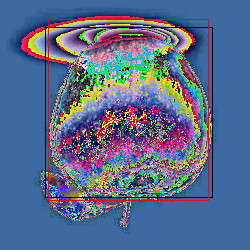

In [ ]:
from PIL import ImageDraw
from torchvision import transforms

image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='black')

print(len(pred['boxes']))
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image